In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve
import gurobipy as gb



In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator28 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator28)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator28)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator28)
# sector1 = Sector('cement', price_demand_function= 150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator28)
# sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator28)
# sector3 = Sector('paper', price_demand_function= 150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator28)
country1 = Country('DE', 1, regulator= Regulator28)
country2 = Country('FI', 0.5, regulator= Regulator28)
country3 = Country('GR', size= 0.1, regulator= Regulator28)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 2*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator28)
firm2 = Firm('firm2', 1, 2, x*0, 3*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator28)
firm3 = Firm('firm3', 1, 3, x*0, 1*x+ 3*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator28)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator28)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator28)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator28)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator28)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator28)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator28)



In [3]:
Regulator28.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [4]:
def optimization_with_least_squares_ab_efficiency_reward(regulator, abatement_reward_multiplier = 0, BAU = False, gurobi_print = False, lp_file = "least_squares_e.lp", print_output = False):
    
        m = Model("Least Squares e")
        
        # Define one pair of output and emission for each firm for sympy and for gurobi and the dictionary of them
        symbol_map = {}
        sympy_output = {}
        sympy_emission = {}
        sympy_abatement = {}
        gurobi_output = {}
        gurobi_abatement = {}
        
        # ab = abatement ab = q - x (output - emission)

        for firm in regulator.firm_registry.values():
            q_sym = sp.symbols(f"q{firm.id}")
            x_sym = sp.symbols(f"x{firm.id}")
            ab_sym = sp.symbols(f"ab{firm.id}")
            sympy_output[firm.id] = q_sym
            sympy_emission[firm.id] = x_sym
            sympy_abatement[firm.id] = ab_sym
            


            qq_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"qq{firm.id}", lb=0)
            ab_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"ab{firm.id}", lb=0)
            gurobi_output[firm.id] = qq_var
            gurobi_abatement[firm.id] = ab_var
            
            symbol_map[q_sym] = qq_var
            symbol_map[ab_sym] = ab_var
            
            m.addConstr(qq_var >= ab_var)
            m.addConstr(ab_var >= 0)
        
        pp = sp.symbols('pp')  # Permit price
        ppp = m.addVar(vtype=gb.GRB.CONTINUOUS, name='ppp', lb=0)
        symbol_map[pp] = ppp
                
        # Define the objective function
        sympy_objective = 0
        for firm in regulator.firm_registry.values():
            firm_profit = 0
            sect = firm.sector
            sum_sector_outputs = 0
            for i in range(len(sect.firms)):
                sum_sector_outputs += sympy_output[sect.firms[i].id]
            firm_revenew = sect.price_demand_function.subs(x, sum_sector_outputs) * sympy_output[firm.id]
            firm_abatement = -firm.abatement_cost_function.subs(x, sympy_abatement[firm.id])
            firm_trading = -pp * (((1 - sect.free_emission_multiplier) * sympy_output[firm.id] - (1+ abatement_reward_multiplier) *sympy_abatement[firm.id]))
            if BAU:
                firm_abatement = 0
                firm_trading = 0
            firm_profit += firm_revenew + firm_abatement + firm_trading
            profit_dq = sp.diff(firm_profit, sympy_output[firm.id])
            profit_dab = sp.diff(firm_profit, sympy_abatement[firm.id])
            sympy_objective += profit_dq **2 + profit_dab **2
            # m.addConstr(sympy_to_gurobi(profit_dq, symbol_map, m) >= 0)
            # m.addConstr(sympy_to_gurobi(profit_dab, symbol_map, m) >= 0)
        # sympy_objective += (regulator.emission_cap + sum(sympy_output.values())- sum(sympy_abatement.values()))**2
        m.addConstr(sum(gurobi_output.values())- sum(gurobi_abatement.values()) == regulator.emission_cap)

        
        # print("Sum sector outputs: {}".format(sum_sector_outputs))
        # print("Sympy Objective: {}".format(sympy_objective))

        gurobi_objective = sympy_to_gurobi(sympy_objective, symbol_map, m)
        m.setObjective(gurobi_objective, gb.GRB.MINIMIZE)
        m.params.OutputFlag = 1 if gurobi_print else 0
        m.write("Least Squares e.lp")
        m.optimize()

        if m.status == gb.GRB.OPTIMAL:
            print("Optimal solution found")
        else:
            print("No solution found")
        
        if BAU:
            for firm in regulator.firm_registry.values():
                firm.BAU_output = gurobi_output[firm.id].X
                firm.BAU_emission = gurobi_output[firm.id].X
            regulator.BAU_emissions = sum([firm.BAU_emission for firm in regulator.firm_registry.values()])
        else:
            for firm in regulator.firm_registry.values():
                firm.actual_output = gurobi_output[firm.id].X
                firm.emission = gurobi_output[firm.id].X - gurobi_abatement[firm.id].X
            regulator.permit_price = ppp.X
        if print_output:
            for firm in regulator.firm_registry.values():
                print(f"Firm {firm.name} has output {firm.actual_output} and emission {firm.emission}")
            print(f"Permit price: {ppp.X}")
        return m
    

In [5]:
def optimize_with_abatement_efficiency_reward(abatement_reward_multiplier = 0, regulator = Regulator28, gurobi_print = False, lp_file = "optimize_with_abatement_efficiency_reward.lp", print_output = False):
    
        m = Model("optimization_concave_formulation_ab")
        
        # Define one pair of output and emission for each firm for sympy and for gurobi and the dictionary of them
        symbol_map = {}
        sympy_output = {}
        sympy_emission = {}
        sympy_abatement = {}
        gurobi_output = {}
        gurobi_abatement = {}
        
        # ab = abatement ab = q - x (output - emission)

        for firm in regulator.firm_registry.values():
            q_sym = sp.symbols(f"q{firm.id}")
            x_sym = sp.symbols(f"x{firm.id}")
            ab_sym = sp.symbols(f"ab{firm.id}")
            sympy_output[firm.id] = q_sym
            sympy_emission[firm.id] = x_sym
            sympy_abatement[firm.id] = ab_sym
            
            qq_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"qq{firm.id}", lb=0)
            ab_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"ab{firm.id}", lb=0)
            gurobi_output[firm.id] = qq_var
            gurobi_abatement[firm.id] = ab_var
            
            symbol_map[q_sym] = qq_var
            symbol_map[ab_sym] = ab_var
            
            m.addConstr(qq_var >= ab_var)
            m.addConstr(ab_var >= 0)
        
        pp = sp.symbols('pp')  # Permit price
        ppp = m.addVar(vtype=gb.GRB.CONTINUOUS, name='ppp', lb=0)
        symbol_map[pp] = ppp
                
        # Define the objective function
        sympy_objective = 0
        for firm in regulator.firm_registry.values():
            firm_profit = 0
            sect = firm.sector
            sum_sector_outputs = 0
            for i in range(len(sect.firms)):
                sum_sector_outputs += sympy_output[sect.firms[i].id]
            firm_revenew = sect.price_demand_function.subs(x, sum_sector_outputs) * sympy_output[firm.id]
            firm_abatement = -firm.abatement_cost_function.subs(x, sympy_abatement[firm.id])
            firm_trading = -pp * (((1 - sect.free_emission_multiplier) * sympy_output[firm.id] - (1+ abatement_reward_multiplier) *sympy_abatement[firm.id]))
            firm_profit += firm_revenew + firm_abatement + firm_trading
            profit_dq = sp.diff(firm_profit, sympy_output[firm.id])
            profit_dab = sp.diff(firm_profit, sympy_abatement[firm.id])
            # sympy_objective += profit_dq + profit_dab
            sympy_objective += - profit_dq - profit_dab
            m.addConstr(sympy_to_gurobi(profit_dq, symbol_map, m) <= 0)
            m.addConstr(sympy_to_gurobi(profit_dab, symbol_map, m) <= 0)
        # sympy_objective += (regulator.emission_cap + sum(sympy_output.values())- sum(sympy_abatement.values()))**2
        m.addConstr(sum(gurobi_output.values())- sum(gurobi_abatement.values()) == regulator.emission_cap)

        
        # print("Sum sector outputs: {}".format(sum_sector_outputs))
        # print("Sympy Objective: {}".format(sympy_objective))
        gurobi_objective = sympy_to_gurobi(sympy_objective, symbol_map, m)
        m.setObjective(gurobi_objective, gb.GRB.MINIMIZE)
        m.params.OutputFlag = 1 if gurobi_print else 0
        m.write(lp_file)
        m.optimize()

        if m.status == gb.GRB.OPTIMAL:
            # print("Optimal solution found")
            pass
        else:
            print("No solution found")
        
        for firm in regulator.firm_registry.values():
            firm.actual_output = gurobi_output[firm.id].X
            firm.emission = gurobi_output[firm.id].X - gurobi_abatement[firm.id].X
        regulator.permit_price = ppp.X
        if print_output:
            for firm in regulator.firm_registry.values():
                print(f"Firm {firm.name} has output {firm.actual_output} and emission {firm.emission}")
            print(f"Permit price: {ppp.X}")
        return m


In [6]:
def equilibrium_tester_abatement_reward(abatement_reward_multiplier = 0, print_header = True,  regulator = Regulator28, precision = 0.001, output = False, full_output = False):
    print_header = print_header and (full_output or output)
    x, y = sp.symbols('x y')
    q1, x1 = sp.symbols('q1 x1')
    firms_data = []
    for sector in regulator.sector_registry.values():
        sum_sector_outputs = 0
        for firm in sector.firms:
            sum_sector_outputs += firm.actual_output
        for firm in sector.firms:

            firm_revenew = sector.price_demand_function.subs(x, sum_sector_outputs - firm.actual_output + q1) * q1
            firm_abatement = -firm.abatement_cost_function.subs({x: q1 - x1, y: x1})
            firm_trading = -regulator.permit_price * (x1 - sector.free_emission_multiplier * q1 - abatement_reward_multiplier * (q1 - x1))
            firm_profit = firm_revenew + firm_abatement + firm_trading
            cond1 = sp.diff(firm_profit, q1)
            cond2 = sp.diff(firm_profit, x1)
            cond3 = sp.diff(firm_profit, x1, 2)
            cond4 = sp.diff(firm_profit, q1, 2)
            # print("Firm {} has cond2: {}".format(firm.name, cond2))
            cond5 = cond3 * cond4 - (sp.diff(firm_profit, q1, x1))**2
            cond1 = cond1.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond2 = cond2.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond3 = cond3.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond4 = cond4.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond5 = cond5.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            firms_data.append([firm.name, cond1, cond2, cond3, cond4, cond5])
    max_FOC_1 = max([abs(firm_data[1]) for firm_data in firms_data])
    max_FOC_2 = max([abs(firm_data[2]) for firm_data in firms_data])
    max_SOC = max([firm_data[3] for firm_data in firms_data])
    max_SOC_2 = max([firm_data[4] for firm_data in firms_data])
    min_Hessian = min([firm_data[5] for firm_data in firms_data])
    firms_data.insert(0, ["Worst", max_FOC_1, max_FOC_2, max_SOC, max_SOC_2, min_Hessian])
    worst_value = max(max_FOC_1, max_FOC_2)

    if output and not full_output:
        firms_data = firms_data[0:1]
        # print(firms_data)
    if print_header:
        # Print table header
        print(f"{'Firm':<10} | {'FOC 1':<12} | {'FOC 2':<13} | {'SOC 1':<13} | {'SOC 2':<12} | {'Hessian':<12} | Status")
        print("-" * 85)
    if full_output or output:

            # Iterate through each firm's data and print the status
        for firm_data in firms_data:
            firm_name, cond1, cond2, cond3, cond4, cond5 = firm_data
            
            # Check each condition and get the status (✔️ or ⚠️)
            cond1_status, cond1_ok = eq_check_condition(cond1, "zero", precision)
            cond2_status, cond2_ok = eq_check_condition(cond2, "zero", precision)
            cond3_status, cond3_ok = eq_check_condition(cond3, "negative")
            cond4_status, cond4_ok = eq_check_condition(cond4, "negative")
            cond5_status, cond5_ok = eq_check_condition(cond5, "positive")
            
            # Calculate how many conditions are OK
            conditions_ok = sum([cond1_ok, cond2_ok, cond3_ok, cond4_ok, cond5_ok])
            
            # Format each condition with scientific notation where necessary
            print(f"{firm_name:<10} | {eq_format_number(cond1)} {cond1_status} | {eq_format_number(cond2)} {cond2_status} | "
                f"{eq_format_number(cond3)} {cond3_status} | {eq_format_number(cond4)} {cond4_status} | "
                f"{eq_format_number(cond5)} {cond5_status} | {conditions_ok}/5")
    
    return abs(firms_data[0][1])<precision and abs(firms_data[0][2])<precision and firms_data[0][3]<0 and firms_data[0][4]<0 and firms_data[0][5]>0, worst_value


In [7]:
def calculate_profit_components_efficiency_reward(firm, abatement_reward_multiplier = 0):
        sector = firm.sector
        regulator = firm.regulator
        # Sum of all other outputs
        sum_other_outputs = 0
        for i in range(len(sector.firms)):
            if sector.firms[i].id != firm.id:
                sum_other_outputs += sector.firms[i].actual_output
        
        permit_price = regulator.permit_price
        price_demand_function = sector.price_demand_function
        production_cost_function = firm.production_cost_function
        abatement_cost_function = firm.abatement_cost_function


        out, em = sp.symbols('out em')
        # Calculate the output of the firm
        income = (price_demand_function.subs(x, sum_other_outputs + out) - production_cost_function.subs(x, out))*out
        firm.sales = income.subs(out, firm.actual_output).evalf()
        firm.abatement = abatement_cost_function.subs({x: firm.actual_output - firm.emission, y: firm.emission}).evalf()
        firm.permits_used = firm.emission
        firm.free_permits = sector.free_emission_multiplier * firm.actual_output +abatement_reward_multiplier * (firm.actual_output - firm.emission)
        firm.permits_bought = firm.permits_used - firm.free_permits
        firm.permits_costs = permit_price * firm.permits_bought
        firm.profit = firm.sales - firm.abatement - firm.permits_costs

In [8]:
# Define the percentages of BAU emissions
cases = [True]
Regulator28.emission_cap = Regulator28.BAU_emissions * 0.8
# Initialize dictionaries to store results for each percentage
results = {case: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'trades1': [], 'trades2': [], 'permits_bought_1': [], 'permits_bought_2': [],
    'permits_free_1': [], 'permits_free_2': [], 'permits_used_1': [], 'permits_used_2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': [],
    'consumer_surplus_1' : [], 'consumer_surplus_2' : []
} for case in cases}

# Loop over each percentage
for case in cases:

    frees = np.linspace(0, 10, 100)

    for free in tqdm.tqdm(frees):
        # optimize_with_abatement_efficiency_reward(abatement_reward_multiplier=free)
        
        Regulator28.optimization_with_least_squares_ab()
        # optimization_with_least_squares_ab_efficiency_reward(regulator= Regulator28, abatement_reward_multiplier=free)
        equilibrium_tester_abatement_reward(output=True, print_header = (free == 0), precision=0.1, abatement_reward_multiplier=free)

        for firm in Regulator28.firm_registry.values():
            calculate_profit_components_efficiency_reward(firm, abatement_reward_multiplier = free)


        results[case]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[case]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[case]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[case]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[case]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[case]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[case]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[case]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[case]['permit_price'].append(Regulator28.permit_price)
        results[case]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[case]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[case]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[case]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))
        results[case]['consumer_surplus_1'].append(sector1.get_consumer_surplus())
        results[case]['consumer_surplus_2'].append((sector2.get_consumer_surplus() + sector3.get_consumer_surplus())/2)
        results[case]['permits_used_1'].append(mean( float(i.permits_used) for i in sector1.firms))
        results[case]['permits_used_2'].append(mean( float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[case]['permits_free_1'].append(mean( float(i.free_permits) for i in sector1.firms))
        results[case]['permits_free_2'].append(mean( float(i.free_permits) for i in sector2.firms + sector3.firms))
        results[case]['permits_bought_1'].append(mean( float(i.permits_bought) for i in sector1.firms))
        results[case]['permits_bought_2'].append(mean( float(i.permits_bought) for i in sector2.firms + sector3.firms))



  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:07<12:09,  7.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0491 ✔️ |  +1.86e-4 ✔️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 5/5
Optimal solution found
Worst      |   +2.7543 ⚠️ |   +2.7055 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


  2%|▏         | 2/100 [00:13<11:16,  6.91s/it]

Optimal solution found


  3%|▎         | 3/100 [00:20<10:55,  6.76s/it]

Worst      |   +5.4596 ⚠️ |   +5.4107 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5
Optimal solution found
Worst      |   +8.1649 ⚠️ |   +8.1160 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


  4%|▍         | 4/100 [00:27<10:51,  6.79s/it]

Optimal solution found
Worst      |  +10.8701 ⚠️ |  +10.8213 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


  5%|▌         | 5/100 [00:34<10:44,  6.78s/it]

Optimal solution found
Worst      |  +13.5754 ⚠️ |  +13.5265 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


  6%|▌         | 6/100 [00:41<10:44,  6.86s/it]

Optimal solution found
Worst      |  +16.2807 ⚠️ |  +16.2318 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


  7%|▋         | 7/100 [00:48<10:40,  6.89s/it]

Optimal solution found
Worst      |  +18.9859 ⚠️ |  +18.9371 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


  8%|▊         | 8/100 [00:54<10:33,  6.89s/it]

Optimal solution found
Worst      |  +21.6912 ⚠️ |  +21.6423 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


  9%|▉         | 9/100 [01:01<10:26,  6.89s/it]

Optimal solution found
Worst      |  +24.3965 ⚠️ |  +24.3476 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 10%|█         | 10/100 [01:08<10:20,  6.89s/it]

Optimal solution found
Worst      |  +27.1017 ⚠️ |  +27.0529 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 11%|█         | 11/100 [01:15<10:15,  6.92s/it]

Optimal solution found
Worst      |  +29.8070 ⚠️ |  +29.7581 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 12%|█▏        | 12/100 [01:22<10:09,  6.92s/it]

Optimal solution found
Worst      |  +32.5123 ⚠️ |  +32.4634 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 13%|█▎        | 13/100 [01:29<10:01,  6.91s/it]

Optimal solution found
Worst      |  +35.2175 ⚠️ |  +35.1687 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 14%|█▍        | 14/100 [01:36<10:00,  6.99s/it]

Optimal solution found
Worst      |  +37.9228 ⚠️ |  +37.8739 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 15%|█▌        | 15/100 [01:43<09:53,  6.99s/it]

Optimal solution found
Worst      |  +40.6281 ⚠️ |  +40.5792 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 16%|█▌        | 16/100 [01:50<09:47,  7.00s/it]

Optimal solution found
Worst      |  +43.3333 ⚠️ |  +43.2845 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 17%|█▋        | 17/100 [01:57<09:40,  6.99s/it]

Optimal solution found
Worst      |  +46.0386 ⚠️ |  +45.9897 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 18%|█▊        | 18/100 [02:04<09:34,  7.00s/it]

Optimal solution found
Worst      |  +48.7439 ⚠️ |  +48.6950 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 19%|█▉        | 19/100 [02:11<09:27,  7.00s/it]

Optimal solution found
Worst      |  +51.4491 ⚠️ |  +51.4003 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 20%|██        | 20/100 [02:18<09:21,  7.01s/it]

Optimal solution found
Worst      |  +54.1544 ⚠️ |  +54.1055 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 21%|██        | 21/100 [02:25<09:14,  7.02s/it]

Optimal solution found
Worst      |  +56.8597 ⚠️ |  +56.8108 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 22%|██▏       | 22/100 [02:32<09:05,  7.00s/it]

Optimal solution found
Worst      |  +59.5649 ⚠️ |  +59.5161 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 23%|██▎       | 23/100 [02:39<09:03,  7.06s/it]

Optimal solution found
Worst      |  +62.2702 ⚠️ |  +62.2213 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 24%|██▍       | 24/100 [02:46<08:51,  6.99s/it]

Optimal solution found
Worst      |  +64.9755 ⚠️ |  +64.9266 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 25%|██▌       | 25/100 [02:53<08:44,  7.00s/it]

Optimal solution found
Worst      |  +67.6807 ⚠️ |  +67.6319 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 26%|██▌       | 26/100 [03:00<08:38,  7.01s/it]

Optimal solution found
Worst      |  +70.3860 ⚠️ |  +70.3371 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 27%|██▋       | 27/100 [03:07<08:32,  7.02s/it]

Optimal solution found
Worst      |  +73.0913 ⚠️ |  +73.0424 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 28%|██▊       | 28/100 [03:14<08:26,  7.03s/it]

Optimal solution found
Worst      |  +75.7965 ⚠️ |  +75.7477 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 29%|██▉       | 29/100 [03:22<08:19,  7.04s/it]

Optimal solution found
Worst      |  +78.5018 ⚠️ |  +78.4529 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 30%|███       | 30/100 [03:29<08:11,  7.03s/it]

Optimal solution found
Worst      |  +81.2071 ⚠️ |  +81.1582 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 31%|███       | 31/100 [03:36<08:08,  7.08s/it]

Optimal solution found
Worst      |  +83.9123 ⚠️ |  +83.8635 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 32%|███▏      | 32/100 [03:42<07:48,  6.89s/it]

Optimal solution found
Worst      |  +86.6176 ⚠️ |  +86.5687 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 33%|███▎      | 33/100 [03:49<07:35,  6.80s/it]

Optimal solution found
Worst      |  +89.3229 ⚠️ |  +89.2740 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 34%|███▍      | 34/100 [03:56<07:30,  6.82s/it]

Optimal solution found
Worst      |  +92.0281 ⚠️ |  +91.9793 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 35%|███▌      | 35/100 [04:02<07:23,  6.82s/it]

Optimal solution found
Worst      |  +94.7334 ⚠️ |  +94.6845 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 36%|███▌      | 36/100 [04:09<07:16,  6.81s/it]

Optimal solution found
Worst      |  +97.4387 ⚠️ |  +97.3898 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 37%|███▋      | 37/100 [04:16<07:07,  6.78s/it]

Optimal solution found
Worst      | +100.1439 ⚠️ | +100.0951 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 38%|███▊      | 38/100 [04:23<06:57,  6.74s/it]

Optimal solution found
Worst      | +102.8492 ⚠️ | +102.8003 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 39%|███▉      | 39/100 [04:29<06:47,  6.67s/it]

Optimal solution found
Worst      | +105.5545 ⚠️ | +105.5056 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 40%|████      | 40/100 [04:36<06:44,  6.75s/it]

Optimal solution found
Worst      | +108.2597 ⚠️ | +108.2109 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 41%|████      | 41/100 [04:43<06:43,  6.84s/it]

Optimal solution found
Worst      | +110.9650 ⚠️ | +110.9161 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 42%|████▏     | 42/100 [04:50<06:40,  6.90s/it]

Optimal solution found
Worst      | +113.6703 ⚠️ | +113.6214 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 43%|████▎     | 43/100 [04:57<06:24,  6.75s/it]

Optimal solution found
Worst      | +116.3755 ⚠️ | +116.3267 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 44%|████▍     | 44/100 [05:03<06:06,  6.55s/it]

Optimal solution found
Worst      | +119.0808 ⚠️ | +119.0319 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 45%|████▌     | 45/100 [05:09<05:57,  6.50s/it]

Optimal solution found
Worst      | +121.7861 ⚠️ | +121.7372 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 46%|████▌     | 46/100 [05:15<05:50,  6.49s/it]

Optimal solution found
Worst      | +124.4913 ⚠️ | +124.4425 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 47%|████▋     | 47/100 [05:22<05:43,  6.49s/it]

Optimal solution found
Worst      | +127.1966 ⚠️ | +127.1477 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 48%|████▊     | 48/100 [05:29<05:39,  6.53s/it]

Optimal solution found
Worst      | +129.9019 ⚠️ | +129.8530 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 49%|████▉     | 49/100 [05:35<05:30,  6.48s/it]

Optimal solution found
Worst      | +132.6071 ⚠️ | +132.5583 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 50%|█████     | 50/100 [05:41<05:20,  6.41s/it]

Optimal solution found
Worst      | +135.3124 ⚠️ | +135.2635 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 51%|█████     | 51/100 [05:47<05:12,  6.37s/it]

Optimal solution found
Worst      | +138.0177 ⚠️ | +137.9688 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 52%|█████▏    | 52/100 [05:54<05:05,  6.36s/it]

Optimal solution found
Worst      | +140.7229 ⚠️ | +140.6741 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 53%|█████▎    | 53/100 [06:00<05:02,  6.44s/it]

Optimal solution found
Worst      | +143.4282 ⚠️ | +143.3793 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 54%|█████▍    | 54/100 [06:07<04:55,  6.43s/it]

Optimal solution found
Worst      | +146.1335 ⚠️ | +146.0846 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 55%|█████▌    | 55/100 [06:13<04:42,  6.28s/it]

Optimal solution found
Worst      | +148.8387 ⚠️ | +148.7899 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 56%|█████▌    | 56/100 [06:19<04:32,  6.19s/it]

Optimal solution found
Worst      | +151.5440 ⚠️ | +151.4951 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 57%|█████▋    | 57/100 [06:25<04:21,  6.08s/it]

Optimal solution found
Worst      | +154.2493 ⚠️ | +154.2004 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 58%|█████▊    | 58/100 [06:31<04:14,  6.06s/it]

Optimal solution found
Worst      | +156.9545 ⚠️ | +156.9057 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 59%|█████▉    | 59/100 [06:37<04:07,  6.03s/it]

Optimal solution found
Worst      | +159.6598 ⚠️ | +159.6109 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 60%|██████    | 60/100 [06:42<03:59,  5.98s/it]

Optimal solution found
Worst      | +162.3651 ⚠️ | +162.3162 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 61%|██████    | 61/100 [06:48<03:53,  5.98s/it]

Optimal solution found
Worst      | +165.0703 ⚠️ | +165.0215 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 62%|██████▏   | 62/100 [06:54<03:47,  5.98s/it]

Optimal solution found
Worst      | +167.7756 ⚠️ | +167.7267 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 63%|██████▎   | 63/100 [07:00<03:41,  6.00s/it]

Optimal solution found
Worst      | +170.4809 ⚠️ | +170.4320 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 64%|██████▍   | 64/100 [07:07<03:37,  6.04s/it]

Optimal solution found
Worst      | +173.1861 ⚠️ | +173.1373 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 65%|██████▌   | 65/100 [07:13<03:31,  6.05s/it]

Optimal solution found
Worst      | +175.8914 ⚠️ | +175.8425 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 66%|██████▌   | 66/100 [07:19<03:25,  6.05s/it]

Optimal solution found
Worst      | +178.5967 ⚠️ | +178.5478 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 67%|██████▋   | 67/100 [07:25<03:18,  6.01s/it]

Optimal solution found
Worst      | +181.3019 ⚠️ | +181.2531 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 68%|██████▊   | 68/100 [07:31<03:11,  6.00s/it]

Optimal solution found
Worst      | +184.0072 ⚠️ | +183.9583 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 69%|██████▉   | 69/100 [07:36<03:04,  5.95s/it]

Optimal solution found
Worst      | +186.7125 ⚠️ | +186.6636 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 70%|███████   | 70/100 [07:42<02:58,  5.95s/it]

Optimal solution found
Worst      | +189.4177 ⚠️ | +189.3689 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 71%|███████   | 71/100 [07:48<02:52,  5.96s/it]

Optimal solution found
Worst      | +192.1230 ⚠️ | +192.0741 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 72%|███████▏  | 72/100 [07:54<02:46,  5.95s/it]

Optimal solution found
Worst      | +194.8283 ⚠️ | +194.7794 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 73%|███████▎  | 73/100 [08:00<02:42,  6.01s/it]

Optimal solution found
Worst      | +197.5336 ⚠️ | +197.4847 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 74%|███████▍  | 74/100 [08:06<02:36,  6.03s/it]

Optimal solution found
Worst      | +200.2388 ⚠️ | +200.1899 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 75%|███████▌  | 75/100 [08:12<02:30,  6.02s/it]

Optimal solution found
Worst      | +202.9441 ⚠️ | +202.8952 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 76%|███████▌  | 76/100 [08:18<02:24,  6.02s/it]

Optimal solution found
Worst      | +205.6494 ⚠️ | +205.6005 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 77%|███████▋  | 77/100 [08:25<02:19,  6.07s/it]

Optimal solution found
Worst      | +208.3546 ⚠️ | +208.3057 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 78%|███████▊  | 78/100 [08:31<02:15,  6.16s/it]

Optimal solution found
Worst      | +211.0599 ⚠️ | +211.0110 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 79%|███████▉  | 79/100 [08:37<02:11,  6.24s/it]

Optimal solution found
Worst      | +213.7652 ⚠️ | +213.7163 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 80%|████████  | 80/100 [08:44<02:06,  6.32s/it]

Optimal solution found
Worst      | +216.4704 ⚠️ | +216.4215 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 81%|████████  | 81/100 [08:50<01:57,  6.21s/it]

Optimal solution found
Worst      | +219.1757 ⚠️ | +219.1268 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 82%|████████▏ | 82/100 [08:56<01:50,  6.16s/it]

Optimal solution found
Worst      | +221.8810 ⚠️ | +221.8321 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 83%|████████▎ | 83/100 [09:02<01:43,  6.10s/it]

Optimal solution found
Worst      | +224.5862 ⚠️ | +224.5373 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 84%|████████▍ | 84/100 [09:08<01:37,  6.10s/it]

Optimal solution found
Worst      | +227.2915 ⚠️ | +227.2426 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 85%|████████▌ | 85/100 [09:14<01:31,  6.09s/it]

Optimal solution found
Worst      | +229.9968 ⚠️ | +229.9479 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 86%|████████▌ | 86/100 [09:20<01:26,  6.16s/it]

Optimal solution found
Worst      | +232.7020 ⚠️ | +232.6531 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 87%|████████▋ | 87/100 [09:27<01:20,  6.17s/it]

Optimal solution found
Worst      | +235.4073 ⚠️ | +235.3584 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 88%|████████▊ | 88/100 [09:33<01:13,  6.12s/it]

Optimal solution found
Worst      | +238.1126 ⚠️ | +238.0637 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 89%|████████▉ | 89/100 [09:39<01:06,  6.06s/it]

Optimal solution found
Worst      | +240.8178 ⚠️ | +240.7689 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 90%|█████████ | 90/100 [09:44<01:00,  6.01s/it]

Optimal solution found
Worst      | +243.5231 ⚠️ | +243.4742 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 91%|█████████ | 91/100 [09:50<00:54,  6.01s/it]

Optimal solution found
Worst      | +246.2284 ⚠️ | +246.1795 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 92%|█████████▏| 92/100 [09:56<00:47,  5.98s/it]

Optimal solution found
Worst      | +248.9336 ⚠️ | +248.8847 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 93%|█████████▎| 93/100 [10:02<00:42,  6.00s/it]

Optimal solution found
Worst      | +251.6389 ⚠️ | +251.5900 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 94%|█████████▍| 94/100 [10:08<00:35,  5.98s/it]

Optimal solution found
Worst      | +254.3442 ⚠️ | +254.2953 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 95%|█████████▌| 95/100 [10:15<00:30,  6.14s/it]

Optimal solution found
Worst      | +257.0494 ⚠️ | +257.0005 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 96%|█████████▌| 96/100 [10:21<00:24,  6.19s/it]

Optimal solution found
Worst      | +259.7547 ⚠️ | +259.7058 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 97%|█████████▋| 97/100 [10:27<00:18,  6.11s/it]

Optimal solution found
Worst      | +262.4600 ⚠️ | +262.4111 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 98%|█████████▊| 98/100 [10:33<00:12,  6.08s/it]

Optimal solution found
Worst      | +265.1652 ⚠️ | +265.1163 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


 99%|█████████▉| 99/100 [10:39<00:06,  6.03s/it]

Optimal solution found
Worst      | +267.8705 ⚠️ | +267.8216 ⚠️ |  -24.6327 ✔️ |  -24.8327 ✔️ |   +4.9265 ✔️ | 3/5


100%|██████████| 100/100 [10:45<00:00,  6.46s/it]


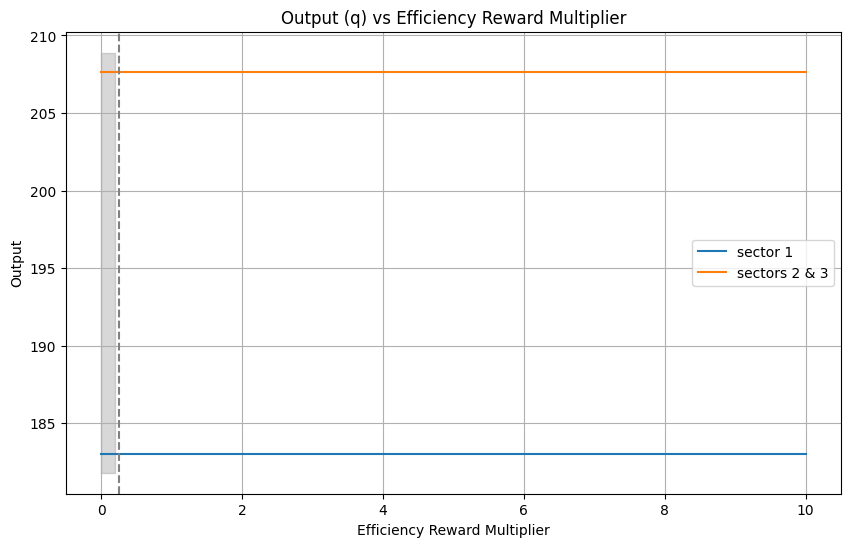

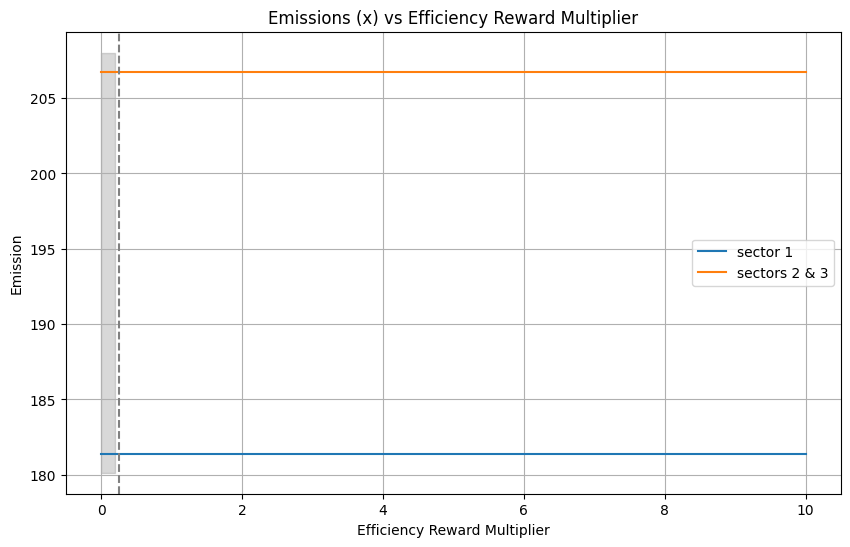

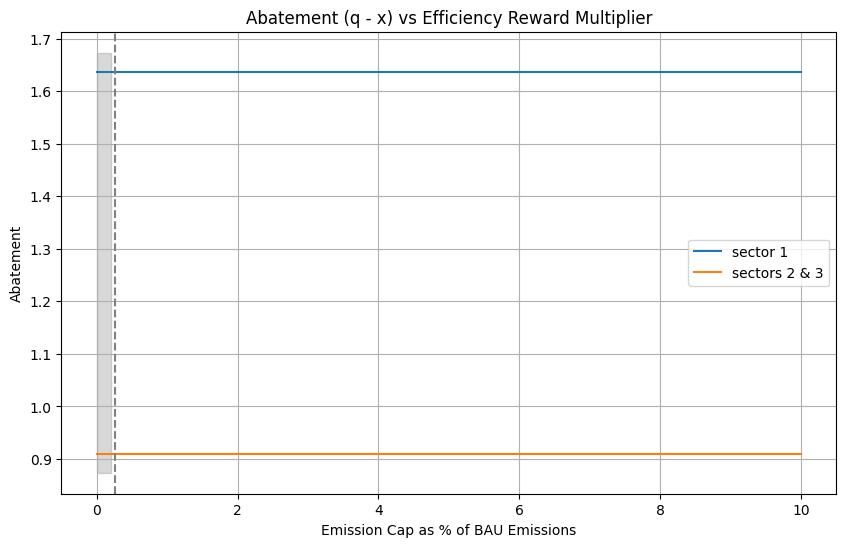

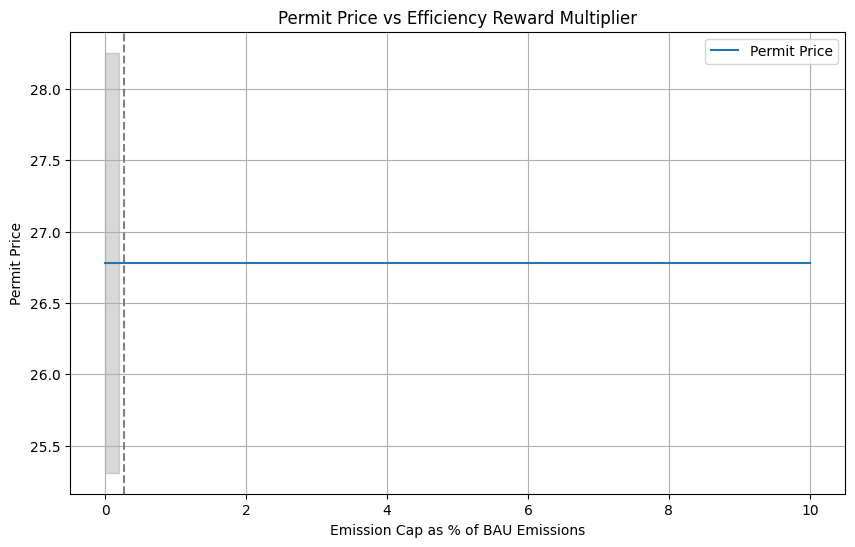

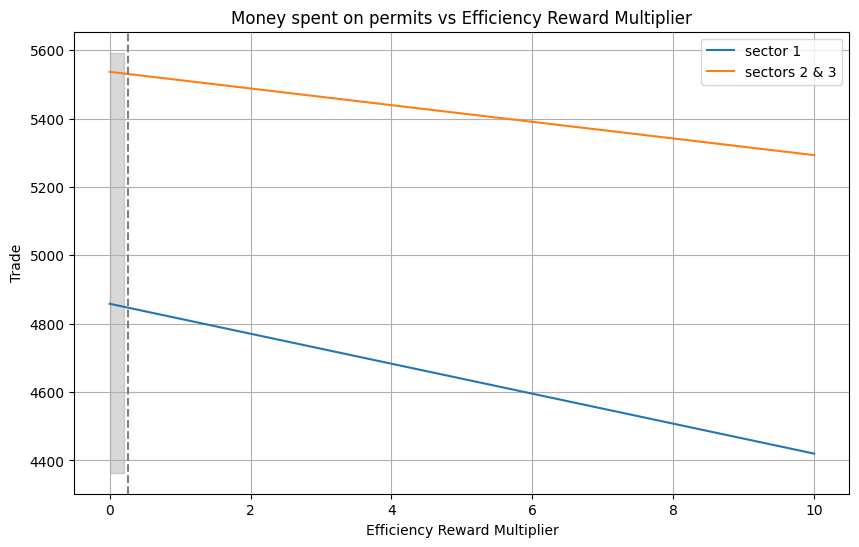

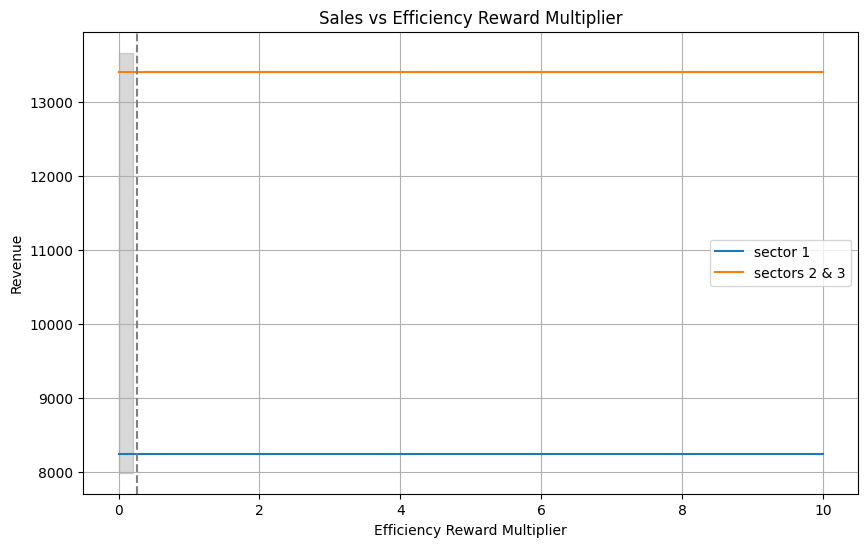

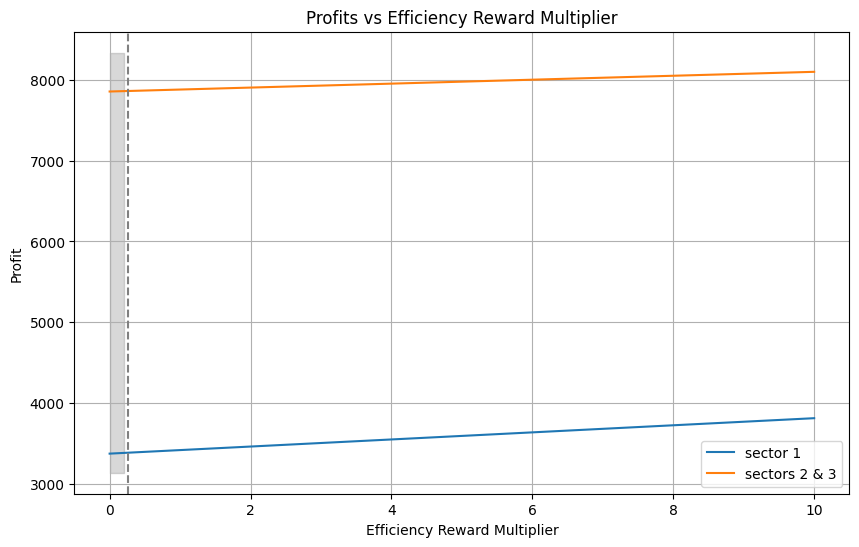

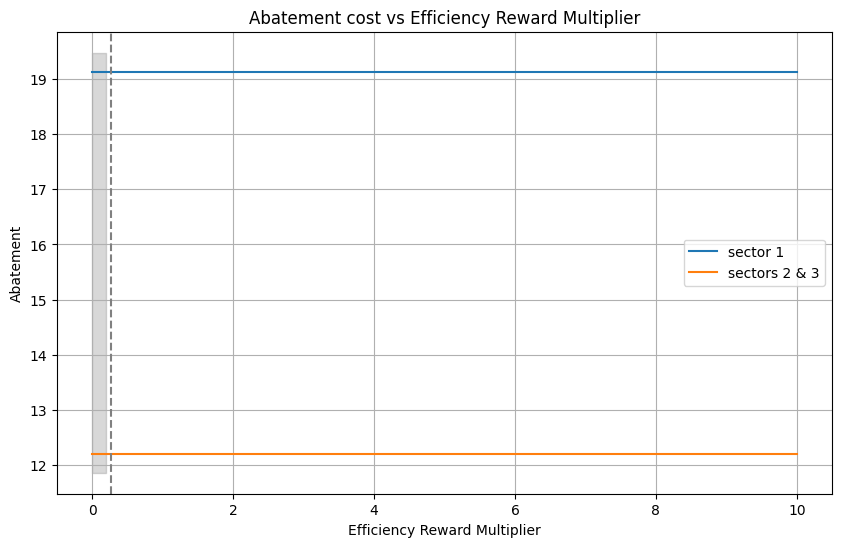

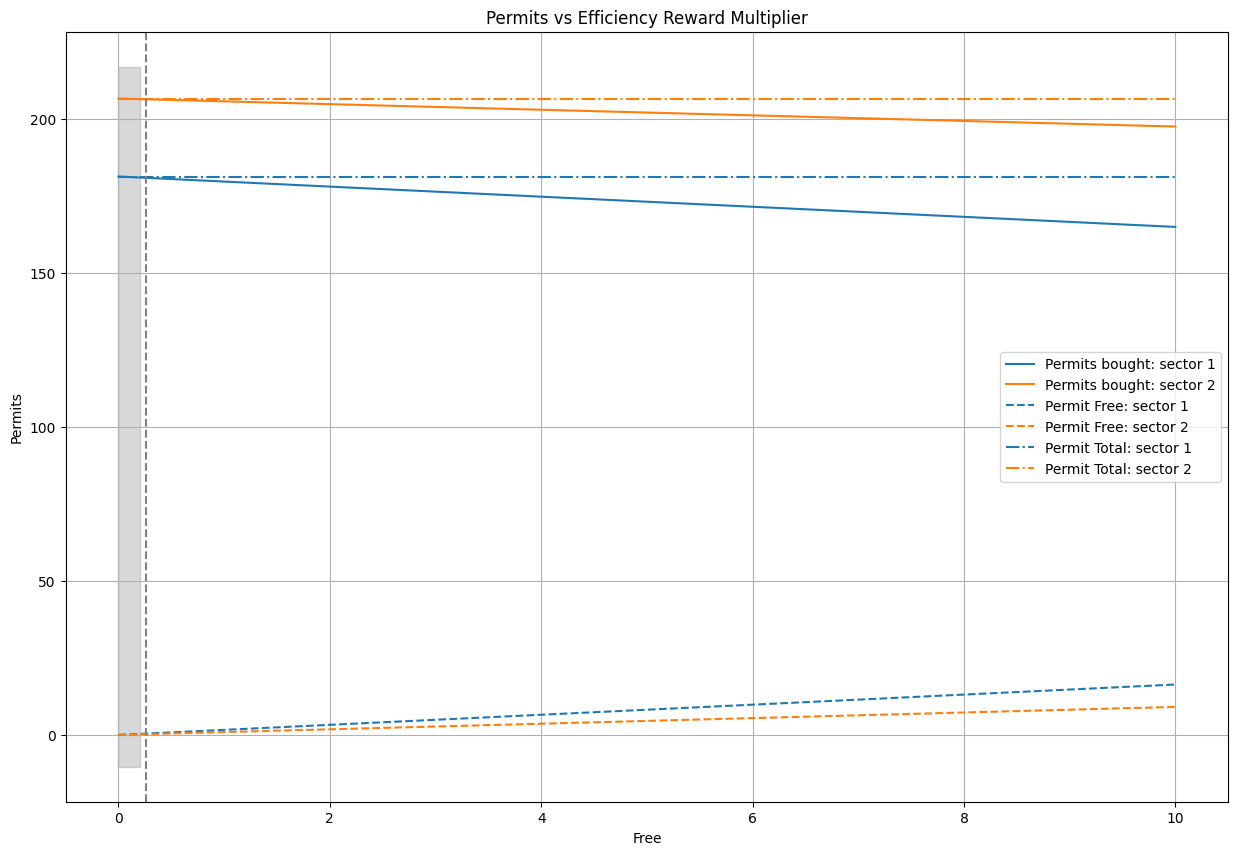

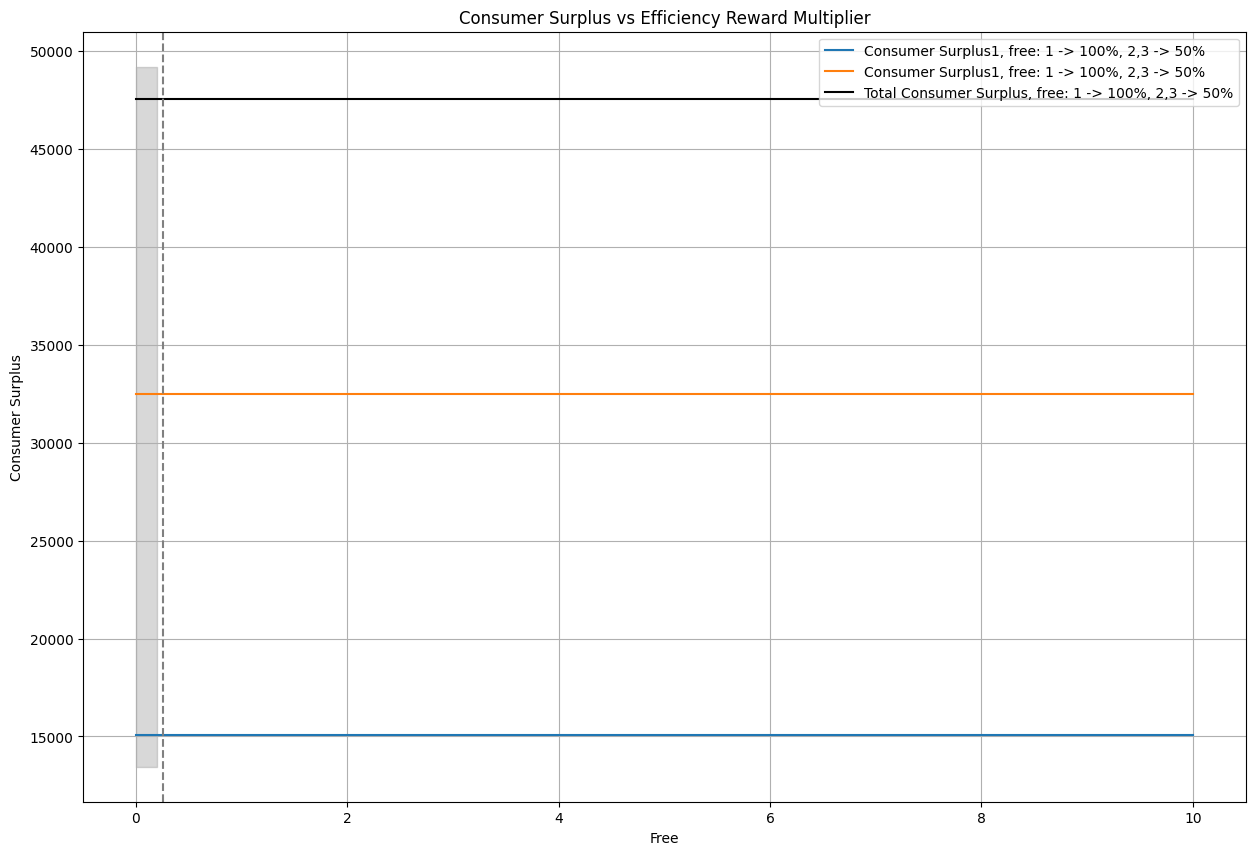

In [9]:
first_value = 0
last_value = 100
# Define colors
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}

last_wrong_value = 0.26

# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(frees, results[True][f'{metric}1'], label='sector 1', color=colors['trades1'])
    plt.plot(frees, results[True][f'{metric}2'], label='sectors 2 & 3', color=colors['trades2'])
    plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
    plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
    plt.xlabel('Efficiency Reward Multiplier')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Efficiency Reward Multiplier')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emissions (x) vs Efficiency Reward Multiplier')

# Plot the difference output - emission to illustrate the abatement
plt.figure(figsize=(10, 6))
plt.plot(frees, np.array(results[True]['outputs1']) - np.array(results[True]['emissions1']), label='sector 1', color=colors['trades1'])
plt.plot(frees, np.array(results[True]['outputs2']) - np.array(results[True]['emissions2']), label='sectors 2 & 3', color=colors['trades2'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Abatement')
plt.title('Abatement (q - x) vs Efficiency Reward Multiplier')
plt.legend()
plt.grid()
plt.show()

# Plot permit prices
plt.figure(figsize=(10, 6))
plt.plot(frees, results[True]['permit_price'], label='Permit Price', color=colors['trades1'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Efficiency Reward Multiplier')
plt.legend()
plt.grid()
plt.show()


# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Efficiency Reward Multiplier')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Efficiency Reward Multiplier')

# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Efficiency Reward Multiplier')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatement cost vs Efficiency Reward Multiplier')


# Plot permits bought, free, and used for each doentage
alphas = {True: 1, False: 0.5}
colors = {'b': '#1f77b4', 'o': '#ff7f0e'}
plt.figure(figsize=(15, 10))
for do in [True]: plt.plot(frees[first_value:last_value], results[do]['permits_bought_1'][first_value:last_value], label=f'Permits bought: sector 1', color=colors['b'], alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_bought_2'][first_value:last_value], label=f'Permits bought: sector 2', color=colors['o'], alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_free_1'][first_value:last_value], label=f'Permit Free: sector 1', color=colors['b'], linestyle='--', alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_free_2'][first_value:last_value], label=f'Permit Free: sector 2', color=colors['o'], linestyle='--', alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_used_1'][first_value:last_value], label=f'Permit Total: sector 1', color=colors['b'], linestyle='-.', alpha=alphas[do])
for do in [True]:plt.plot(frees[first_value:last_value], results[do]['permits_used_2'][first_value:last_value], label=f'Permit Total: sector 2', color=colors['o'], linestyle='-.', alpha=alphas[do])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Permits')
plt.title('Permits vs Efficiency Reward Multiplier')
plt.legend()
plt.grid()
plt.show()



from operator import add
plt.figure(figsize=(15, 10))
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_1'][first_value:last_value], label=f'Consumer Surplus1, free: 1 -> 100%, 2,3 -> 50%', color=colors['b'])
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_2'][first_value:last_value], label=f'Consumer Surplus1, free: 1 -> 100%, 2,3 -> 50%', color=colors['o'])
plt.plot(frees[first_value:last_value], list( map(add,results[True]['consumer_surplus_1'], results[True]['consumer_surplus_2']))[first_value:last_value], label=f'Total Consumer Surplus, free: 1 -> 100%, 2,3 -> 50%', color='black')
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Consumer Surplus')
plt.title('Consumer Surplus vs Efficiency Reward Multiplier')
plt.legend()
plt.grid()
plt.show()